In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.circuit.library import ExactReciprocal
from qiskit.extensions import HamiltonianGate
from qiskit.quantum_info import random_hermitian
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

In [3]:
def HHL(circ, qreg, qanc, qtarg, A, t=2.*np.pi, scaling=None, wrap=False, inverse=False, neg_vals=True, label='HHL'):
        
    n = len(qreg)
    nanc = len(qanc)

    if inverse:
        wrap = True

    if wrap:
        qreg = QuantumRegister(n, 'q_reg')
        qanc = QuantumRegister(nanc, 'q_anc')
        qtarg = QuantumRegister(1, 'q_targ')
        circ = QuantumCircuit(qreg, qanc, qtarg)

    A_gate = HamiltonianGate(A, t)
        
    qe_gate = qt.PhaseEst(circ, qreg, qanc, A_gate, wrap=True, do_swaps=False, reverse_bits=True)
    circ.append(qe_gate, [*qreg, *qanc]);
        
    rec_gate = ExactReciprocal(nanc, scaling=scaling, neg_vals=neg_vals).to_gate()
    circ.append(rec_gate, [*qanc[::-1], qtarg]);

    qe_gate_inv = qt.PhaseEst(circ, qreg, qanc, A_gate, wrap=True, inverse=True, do_swaps=False, reverse_bits=True)
    circ.append(qe_gate_inv, [*qreg, *qanc]);
    
    if wrap:
        circ = circ.to_gate()
        circ.label = label

    if inverse:
        circ = circ.inverse()
        circ.label = label+'\dag'

    return circ

In [4]:
A = random_hermitian(2).to_matrix()
print(A)

[[1.97671356 1.26830923 0.91486207 0.53077005]
 [1.26830923 1.97671356 1.26830923 0.91486207]
 [0.91486207 1.26830923 1.97671356 1.26830923]
 [0.53077005 0.91486207 1.26830923 1.97671356]]


In [5]:
def get_delta(n_l, lambda_min, lambda_max):
    formatstr = "#0" + str(n_l + 2) + "b"
    lambda_min_tilde = np.abs(lambda_min * (2**n_l - 1) / lambda_max)
    # floating point precision can cause problems
    if np.abs(lambda_min_tilde - 1) < 1e-7:
        lambda_min_tilde = 1
    binstr = format(int(lambda_min_tilde), formatstr)[2::]
    lamb_min_rep = 0
    for i, char in enumerate(binstr):
        lamb_min_rep += int(char) / (2 ** (i + 1))
    return lamb_min_rep

In [6]:
phase = True

lambda_min = np.min(np.abs(np.linalg.eigvals(A)))
lambda_max = np.max(np.abs(np.linalg.eigvals(A)))
kappa = np.abs(lambda_max/lambda_min)

nanc = np.max([int(np.log2(A.shape[0])) + 1, int(np.ceil(np.log2(kappa + 1)))]) + phase

scaling = get_delta(nanc - phase, lambda_min, lambda_max)
t0 = scaling / (lambda_min * (2**phase))
t = 2 * np.pi * t0

print(t, scaling, nanc, kappa, lambda_min, lambda_max)

0.34667784768632276 0.0625 5 8.9876035990045 0.5663746390482408 5.0903507442948435


In [7]:
n = int(np.log2(A.shape[0]))

In [8]:
qreg = QuantumRegister(n, 'q_reg')
circ = QuantumCircuit(qreg)

In [9]:
#circ.h(qreg[0]);
circ.x(qreg[0]);

In [10]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
in_vector = np.asarray(result.get_statevector())

In [11]:
print(in_vector)

[0.+0.j 1.+0.j 0.+0.j 0.+0.j]


In [12]:
qanc = QuantumRegister(nanc, 'q_anc')
qtarg = QuantumRegister(1, 'q_targ')

circ.add_register(qanc, qtarg)

In [13]:
circ = HHL(circ, qreg, qanc, qtarg, A, t=t, scaling=scaling)

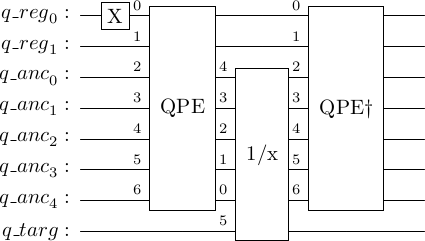

In [14]:
circ.draw('latex')

In [15]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

In [16]:
state_v = np.asarray(state_vector).reshape((2**1,2**nanc,2**n))

In [17]:
# 1, nanc, n
print(state_v.shape)

(2, 32, 4)


In [18]:
norm_ = np.sqrt(np.sum(np.abs(state_v[1])**2))
print(norm_)

0.797482187918711


In [19]:
state_v = state_v[1,0]

In [20]:
print(state_v)

[-0.31564634-1.29156699e-15j  0.67876498+7.56904195e-16j
 -0.22869925-4.32713933e-16j -0.08536698+5.76667097e-16j]


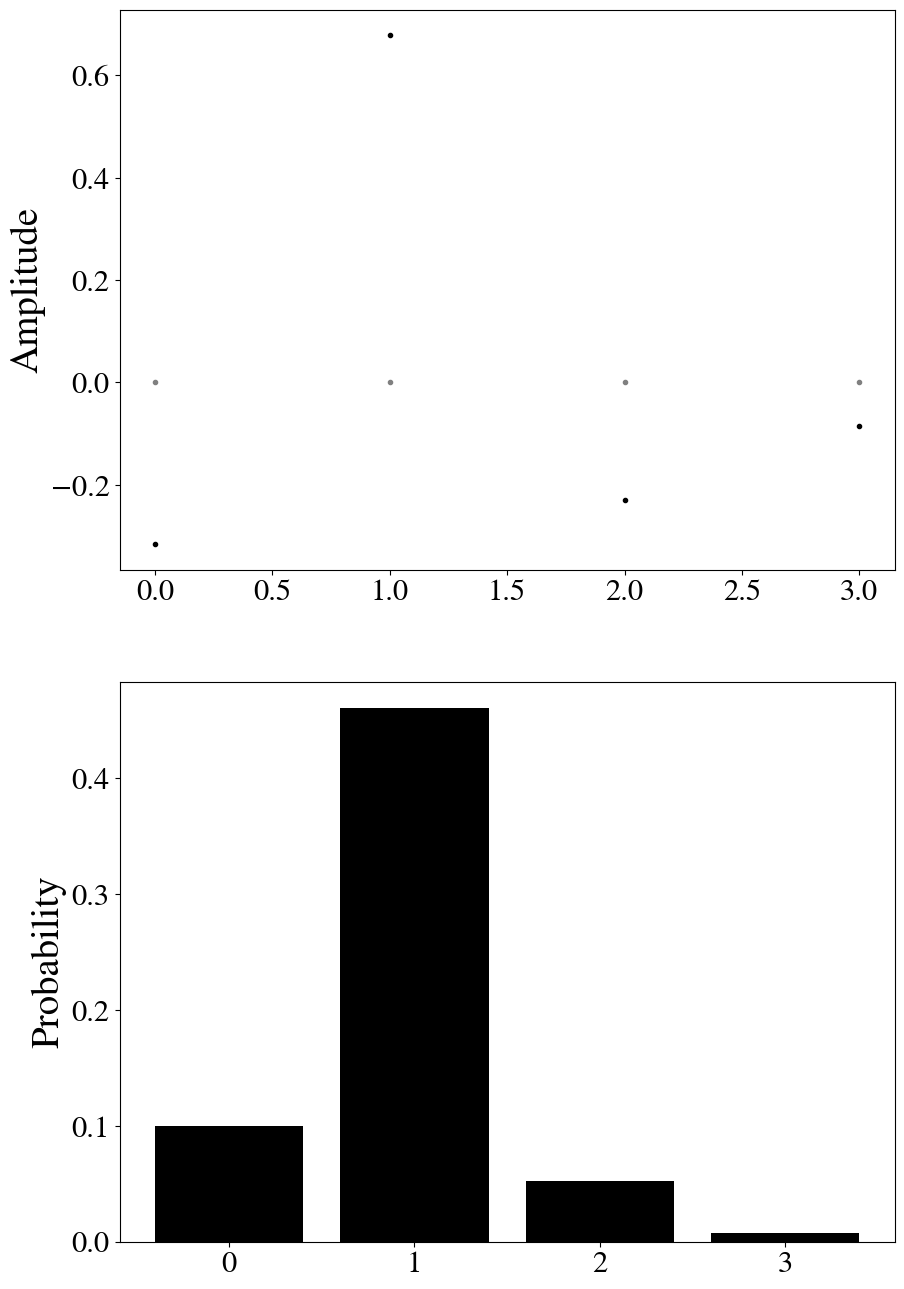

In [21]:
fig = plt.figure(figsize=np.array(figsize)*[1,2])
ax = fig.add_subplot(211)

plt.scatter(np.arange(2**n), state_v.real, marker='.', color='black')
plt.scatter(np.arange(2**n), state_v.imag, marker='.', color='grey')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

ax = fig.add_subplot(212)

plt.bar(np.arange(2**n), np.abs(state_v)**2, color='black')
ax.set_ylabel('Probability', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

In [22]:
state_v = state_v.real/np.sqrt(np.sum(np.abs(state_v)**2))

In [23]:
targ = np.matmul(np.linalg.inv(A),in_vector).real

In [24]:
norm = norm_/lambda_min

In [25]:
out = state_v*norm

In [26]:
print(out, targ)

[-0.56447048  1.2138357  -0.40898297 -0.15266181] [-0.52034776  1.17581228 -0.43188531 -0.12736136]


In [27]:
out/targ

array([1.08479467, 1.03233801, 0.94697125, 1.19865095])